In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import math
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm,trange

from shutil import rmtree

from scipy.signal import savgol_filter

from numpy.linalg import inv

In [2]:
def get_angle(dx,dy,scale=5):
    dx = dx*scale
    dy = dy*scale

    angle = np.degrees(np.pi*2 + math.atan2(dy, dx))%360
    return angle

def get_xy(center,depth,P,c=0):
    
    center = np.array(center).reshape((1,2))
    depth = np.array(depth).reshape(1,1)

    return imagetocamera(center,depth,P)

def imagetocamera(points, depth, projection):
    """
    points: (N, 2), N points on X-Y image plane
    depths: (N,), N depth values for points
    projection: (3, 4), projection matrix
    corners: (N, 3), N points on X(right)-Y(down)-Z(front) camera coordinate
    """
    assert points.shape[1] == 2, "Shape ({}) not fit".format(points.shape)

    corners = np.hstack([points, np.ones(
        (points.shape[0], 1))]).dot(inv(projection[:, 0:3]).T)
    assert np.allclose(corners[:, 2], 1)
    corners *= depth.reshape(-1, 1)

    return list(corners[0])

def read_calib(path):
    with open(path, 'r') as f:
        lines = f.readlines()
        P2 = np.array(lines[2].strip().split(' ')[1:], dtype=np.float32).reshape(3, 4)
        
    return P2

In [3]:
def smoothing(df,columns,window_size=17,order=3):
    if len(df) < window_size:
        window_size = len(df)
    
    if window_size <= order:
        return df
    
#     print(window_size,order)
    for col in columns:
        df[col] = savgol_filter(df[col], len(df), order, mode='interp')
        
    return df

In [4]:
BASE_DIR_calib = '/home/alfin/Documents/deep_learning/production/centernet_3d_fish/'
# BASE_DIR = BASE_DIR_calib
BASE_DIR = '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/'
# BASE_DIR = '/home/alfin/Documents/deep_learning/fish_conversion/data/general_eval/KITTI/detection/training/'

IMG_DIR = os.path.join(BASE_DIR,'output_3_pad/')
# IMG_DIR = os.path.join(BASE_DIR,'image_2/')
INF_DIR = os.path.join(BASE_DIR,'association_inference/')
CALIB_DIR = os.path.join(BASE_DIR_calib,'data/')

data_path = [{'img':IMG_DIR+img,'inf':INF_DIR+inf
             } for img,inf in 
             zip(sorted(os.listdir(IMG_DIR)),
                 sorted([x for x in os.listdir(INF_DIR) if not x.endswith('angle.txt')])
                
#                  sorted([x for x in os.listdir(INF_DIR) if x.endswith('track.txt')])
                )]
calib_path = os.path.join(CALIB_DIR,'000000.txt')

In [5]:
len(data_path)

300

In [6]:
data_path

[{'img': '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/output_3_pad/000000.jpg',
  'inf': '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/association_inference/000000.txt'},
 {'img': '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/output_3_pad/000001.jpg',
  'inf': '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/association_inference/000001.txt'},
 {'img': '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/output_3_pad/000002.jpg',
  'inf': '/home/alfin/Documents/deep_learning/fish_conversion/data/20221121_centernet_rxry/KITTI/detection/training/sample_video/association_inference/000002.txt'},
 {'img': '/home/alfin/Documents/deep_lea

In [7]:
img_input_size = (512,512)

inf_header = ['h','w','l','z','alphax','alphay','conf','idx','cx','cy','xmin','ymin','xmax','ymax','id']

all_data = []
for j,data in tqdm(enumerate(data_path[:])):

    ann = pd.read_csv(data['inf'],sep = ' ',names=inf_header)
    for i in range(len(ann)):
        label = ann.iloc[i]

        label_dict = label.to_dict()
        label_dict['filename'] = data['inf']
        all_data.append(label_dict)


300it [00:00, 655.73it/s]


In [8]:
df_input = pd.DataFrame(all_data)
df_input = df_input.drop_duplicates(keep=False)
df_output = None

In [ ]:
df_input['filename']

In [11]:
window_size = 5
scale = 3

df_num = df_input['id'].value_counts()
df_filtered = df_input[df_input['id'].isin(df_num[df_num >= window_size].index)]

smooth_columns=['alphax', 'alphay','w','h','l']

In [12]:
P = read_calib(calib_path)

for fish_id in df_filtered['id'].unique():
    df = df_filtered[df_input['id']==fish_id].sort_values('idx')
    
    df = smoothing(df,smooth_columns,window_size=5,order=4)
    
    df = df.reset_index(drop=True)
#     df['h'] = float(df['h'].mean())
#     df['w'] = float(df['w'].mean())
#     df['l'] = float(df['l'].mean())
    
#     num_groups = len(df)//window_size
#     rows_per_group = len(df) // num_groups
#     df['group'] = df.index // rows_per_group
    
    
#     for group_id in df['group'].unique():
#         df_group = df[df['group'] == group_id]
        
#         df1 = df_group.iloc[0]
#         df2 = df_group.iloc[-1]
        
#         dx = df2['cx'] - df1['cx']
#         dy = df2['cy'] - df1['cy']
        
#         angle = get_angle(dx,dy)
#         df_group['angle'] = angle
        
#         3d center
#         center1 = (df1['cx'],df1['cy'])
#         x1,y1,z1 = get_xy(center1,df1['z'],P)
        
#         center2 = (df2['cx'],df2['cy'])
#         x2,y2,z2 = get_xy(center2,df2['z'],P)
        
#         dx = (x2-x1)*scale
#         dy = (y2-y1)*scale
#         dz = (z2-z1)*scale
        
#         rx = get_angle(dx,dy,scale = 100)
#         ry = get_angle(dx,dz,scale = 100)
#         rz = get_angle(dy,dz,scale = 100)
        
#         df_group['rx'] = rx
#         df_group['ry'] = ry
#         df_group['rz'] = rz
        
#         df_group['alphax'] = float(df_group['alphax'].mean())
#         df_group['alphay'] = float(df_group['alphay'].mean())
        
#         print(dx,dy,dz)
        
#         dxyX = df_group.iloc[-1]['cx'] - df_group.iloc[0]['cx']
        
#         if df_output is None:
#             df_output = df_group
#         else:
#             df_output = pd.concat([df_output, df_group])
            
df_output = df.reset_index(drop=True)

/tmp/ipykernel_208077/3654929563.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df_filtered[df_input['id']==fish_id].sort_values('idx')


In [11]:
df

,h,w,l,z,alphax,alphay,conf,idx,cx,cy,xmin,ymin,xmax,ymax,id,filename
0,0.153506,0.069951,0.352405,0.483665,0.375657,7.043433,0.972599,284.0,376.0,133.0,257.759003,49.104366,367.048309,157.202637,213.0,/home/alfin/Documents/deep_learning/fish_conve...
1,0.157674,0.071587,0.362231,0.820388,1.187260,5.757233,0.907234,285.0,316.0,102.0,267.043884,53.938587,366.987701,152.575470,213.0,/home/alfin/Documents/deep_learning/fish_conve...
2,0.158359,0.072060,0.363164,0.767626,1.806000,4.772430,0.944831,286.0,325.0,109.0,273.591034,58.118382,374.587280,157.507431,213.0,/home/alfin/Documents/deep_learning/fish_conve...
3,0.153799,0.069977,0.352565,0.790853,2.250990,4.059929,0.838967,287.0,329.0,109.0,277.017181,59.364601,382.819244,163.233932,213.0,/home/alfin/Documents/deep_learning/fish_conve...
4,0.154939,0.070607,0.355000,0.823869,2.541342,3.590633,0.797795,288.0,337.0,109.0,284.742157,59.576443,392.325287,164.842636,213.0,/home/alfin/Documents/deep_learning/fish_conve...
5,0.148000,0.067717,0.339876,0.839880,2.696169,3.335444,0.495773,289.0,353.0,117.0,290.902405,60.157082,398.271606,164.839050,213.0,/home/alfin/Documents/deep_learning/fish_conve...
6,0.152008,0.069148,0.348184,0.812104,2.734582,3.265268,0.865770,290.0,348.0,112.0,297.610016,61.387547,404.472046,165.000198,213.0,/home/alfin/Documents/deep_learning/fish_conve...
7,0.154412,0.070577,0.354693,0.751204,2.675693,3.351008,0.914254,291.0,368.0,120.0,300.787994,62.287186,413.202026,170.958328,213.0,/home/alfin/Documents/deep_learning/fish_conve...
8,0.149402,0.068410,0.342631,0.702868,2.538615,3.563566,0.907358,292.0,372.0,122.0,306.699341,63.074638,418.276306,170.278580,213.0,/home/alfin/Documents/deep_learning/fish_conve...
9,0.148953,0.067830,0.340803,0.719207,2.342460,3.873847,0.897079,293.0,366.0,116.0,310.627563,62.547199,422.676361,169.132736,213.0,/home/alfin/Documents/deep_learning/fish_conve...


In [13]:
filenames = list(df_output['filename'].unique())
for filename in filenames:
    df_file = df_output[df_output['filename']==filename]
#     df_file = df_file[inf_header+['angle','rx','ry','rz']]
    df_file = df_file[inf_header]
    
    save_path = os.path.splitext(filename)[0]+'_angle.txt'
    df_file.to_csv(save_path,header=False,sep=' ',index=False)

In [14]:
len(filenames)

11

In [33]:
d = df_input.copy()

In [80]:
d_1 = d[d['id']==1]

,h,w,l,z,alphax,alphay,conf,idx,cx,cy,xmin,ymin,xmax,ymax,id,filename
0,0.142468,0.064928,0.326980,0.970609,4.880556,5.541615,0.922215,0.0,349.0,240.0,302.0,203.0,397.0,277.0,1.0,/home/alfin/Documents/deep_learning/fish_conve...
28,0.141658,0.064566,0.325104,0.978892,4.855808,5.534105,0.922598,1.0,346.0,240.0,300.0,204.0,393.0,276.0,1.0,/home/alfin/Documents/deep_learning/fish_conve...
56,0.141709,0.064452,0.325702,0.993210,4.872114,5.524654,0.921537,2.0,343.0,241.0,297.0,205.0,389.0,277.0,1.0,/home/alfin/Documents/deep_learning/fish_conve...
86,0.144915,0.065863,0.333294,1.014659,4.921448,5.554479,0.913483,3.0,339.0,242.0,293.0,206.0,385.0,278.0,1.0,/home/alfin/Documents/deep_learning/fish_conve...
116,0.139713,0.063552,0.321177,0.964319,4.864556,5.536318,0.912934,4.0,335.0,242.0,290.0,207.0,381.0,278.0,1.0,/home/alfin/Documents/deep_learning/fish_conve...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2863,0.152778,0.069423,0.350774,0.974444,2.322382,5.590160,0.895142,103.0,473.0,283.0,420.0,242.0,527.0,324.0,1.0,/home/alfin/Documents/deep_learning/fish_conve...
2888,0.148725,0.067650,0.341780,1.219558,2.356268,5.482297,0.741968,104.0,478.0,284.0,427.0,243.0,530.0,325.0,1.0,/home/alfin/Documents/deep_learning/fish_conve...
2913,0.146139,0.066826,0.334506,1.079041,2.161753,5.575717,0.714025,105.0,484.0,285.0,435.0,245.0,533.0,326.0,1.0,/home/alfin/Documents/deep_learning/fish_conve...
2938,0.150270,0.068550,0.344980,1.381698,1.910911,6.078478,0.604354,106.0,489.0,287.0,445.0,249.0,533.0,325.0,1.0,/home/alfin/Documents/deep_learning/fish_conve...


<AxesSubplot: >

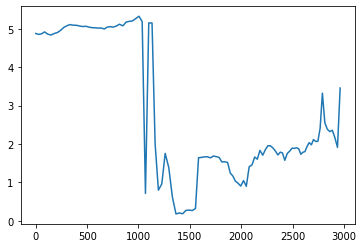

In [83]:
# column_taken = ['alphax']
d_1['alphax'].plot()

<AxesSubplot: >

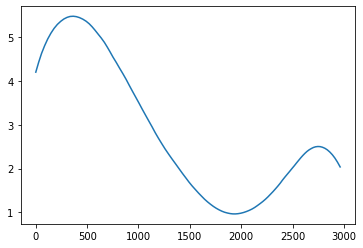

In [87]:
smoothing(d_1.copy(),['alphax'],window_size=5,order=4)['alphax'].plot()

<AxesSubplot: >

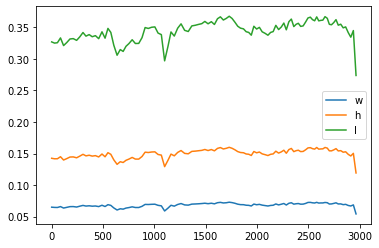

In [50]:
d_1.plot()